In [1]:
import numpy as np
from matplotlib import pyplot as plt
from random import randint
from matplotlib.path import Path
import matplotlib.patches as patches

# 1.7 Six Degrees of Separation

The $L$ nodes in a small world network are arranged around a circle. There are two kinds of edges. Each node has $Z$ short edges connecting it to its nearest neighbors around the circle (up to a distance $Z/2$). In addition, there are $p \times L \times Z/2$ shortcuts added to the network, which connect nodes at random.

## Note
The software that is supposed to be provided to draw the network doesn't exist. Instead we wrote our own.

In [2]:
def DrawNetwork(num_nodes, connections, radius=1):
    def node_positions(L, radius):
        nodelist = []
        theta = 0
        nodesep = 2 * np.pi / L
        while len(nodelist)<L:
            x = radius*np.cos(theta)
            y = radius*np.sin(theta)
            nodelist.append([x,y])
            theta += nodesep
        return np.array(nodelist)

    # currently inefficient in that it double counts [a,b] and [b,a]
    def node_connections(nodelist, connectivity):
        linelist = []
        for idx, val in np.ndenumerate(connectivity):
            if val == 1: 
                line = [nodelist[idx[0]], nodelist[idx[1]]]
                linelist.append(line)
        return linelist

    def connections_paths(linelist):
        paths =[]
        for line in linelist:
            codes = [Path.MOVETO, Path.LINETO]
            paths.append(patches.PathPatch(Path(line, codes), ec='r'))
        return paths

    plotlims = 1.5*radius*np.array([-1,1])

    nodelist = node_positions(num_nodes, radius)
    linelist = node_connections(nodelist, connections)
    pathlist = connections_paths(linelist)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(nodelist[:,0], nodelist[:,1])
    for path in pathlist: ax.add_patch(path)
    ax.set(xlim=plotlims, ylim=plotlims)
    plt.show()
    plt.close()

# a)
Define a network object/class. It should have the following functions:
1. `HasNode(node)`, which checks to see if a node is already in the network;
2. `AddNode(node)`, which adds a new node to the system (if it is not already there);
3. `AddEdge(node1, node2)`, which adds a new edge to the system;
4. `GetNodes()`, which returns a list of existing nodes; and
5. `GetNeighbors(node)`, which returns the neighbors of an existing node.

In [3]:
class Network:
    def __init__(self, Z):
        self.numNodes = 0
        self.nodeList = []
        self.edges = set()
        self.Z = Z

    def HasNode(self,node):
        if node in self.nodeList: return True
        return False

    def AddNode(self,node):
        if not self.HasNode(node): self.nodeList.append(node)

    def AddEdge(self,node1,node2):
        self.edges.add((node1,node2))

    def GetNodes(self):
        return self.nodeList

    def GetNeighbours(self, node):
        neighbours = []

        def AreConnected(graph, node1,node2):
            if (node1, node2) in graph.edges: return True
            elif (node2, node1) in graph.edges: return True
            return False

        for item in self.nodeList:
            if AreConnected(self, node, item):
                neighbours.append(item)
        return neighbours

Write a routine to construct a small world network, which (given $L$, $Z$, and $p$) adds the nodes and the short edges, and then randomly adds the
shortcuts.

In [4]:
def ConstructNetwork(L,Z,p, returnNetwork=False):
    # instantiate the network
    n = Network(Z=Z)
    for i in range(L): n.AddNode(i)
    nodeList = n.GetNodes()

    def ConnectNearby(graph, node):
        # connects a node to nearby nodes - making them neighbours

        def GetNearby(graph, node):
            # finds nodes within a range of Z/2 of the input node
            idx = graph.nodeList.index(node)
            nearby = []
            for dist in range(int(np.ceil(graph.Z/2))):
                back, forward = idx-dist-1, idx+dist+1
                for i in (back, forward):
                    try: # deal with index out of range errors
                        nearby.append(graph.nodeList[i])
                    except IndexError: pass
            return nearby

        for newNeighbour in GetNearby(graph, node):
            graph.AddEdge(node, newNeighbour)

    # add the short edges
    for node in nodeList: ConnectNearby(n, node)

    # add the shortcuts
    numShortcuts = int(p*L*Z/2)
    for i in range(numShortcuts):
        node1 = nodeList[randint(0,L-1)]
        node2 = nodeList[randint(0,L-1)]
        n.AddEdge(node1, node2)

    # create a connectivity matrix for the drawing function
    connectivity = np.zeros((L,L))
    for edge in n.edges:
        connectivity[edge[0], edge[1]] = 1

    if returnNetwork: return connectivity, n
    else: return connectivity

Draw this small world graph, and check that you have implemented the periodic boundary conditions correctly (each node $i$ should be connected to nodes $(i − Z/2) \mod L, \dots, (i + Z/2) \mod L)$.

Node (i) 	 i-Z/2 mod L 	 i+Z/2 mod L 	 Connected to
0		 18		 2		 [1, 2, 18, 19]
1		 19		 3		 [0, 2, 3, 8, 9, 19]
2		 0		 4		 [0, 1, 3, 4, 12]
3		 1		 5		 [1, 2, 4, 5]
4		 2		 6		 [2, 3, 5, 6]
5		 3		 7		 [3, 4, 6, 7]
6		 4		 8		 [4, 5, 7, 8]
7		 5		 9		 [5, 6, 8, 9, 15]
8		 6		 10		 [1, 6, 7, 9, 10]
9		 7		 11		 [1, 7, 8, 10, 11]
10		 8		 12		 [8, 9, 10, 11, 12, 13]
11		 9		 13		 [9, 10, 12, 13, 17]
12		 10		 14		 [2, 10, 11, 13, 14]
13		 11		 15		 [10, 11, 12, 14, 15]
14		 12		 16		 [12, 13, 15, 16]
15		 13		 17		 [7, 13, 14, 16, 17]
16		 14		 18		 [14, 15, 17, 18]
17		 15		 19		 [11, 15, 16, 18, 19]
18		 16		 0		 [0, 16, 17, 19]
19		 17		 1		 [0, 1, 17, 18]


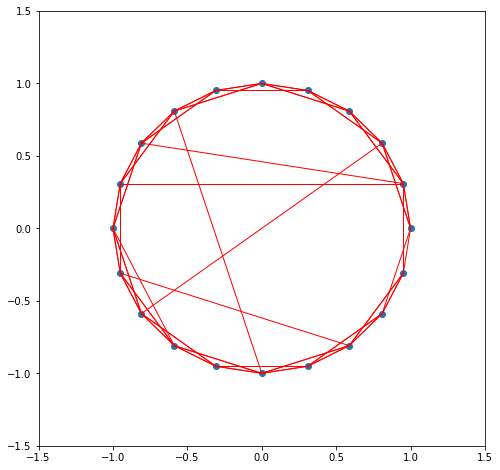

In [5]:
L, Z, p = 20, 4, .2
testC, testNetwork = ConstructNetwork(L, Z, p, returnNetwork=True)
edges = testNetwork.edges

print('Node (i) \t i-Z/2 mod L \t i+Z/2 mod L \t Connected to')
for i in range(L):
    edgesi = [edge for edge in edges if i in edge]
    connected = []
    for edge in edges:
        if i in edge:
            newNode = edge[edge.index(i)-1]
            if newNode not in connected: connected.append(newNode)
            connected.sort()
    print(f'{i}\t\t {int((i-Z/2)%L)}\t\t {int((i+Z/2)%L)}\t\t {connected}')

DrawNetwork(L,testC)

# b) 
Write the following functions:
1. `FindPathLengthsFromNode(graph, node)`, which returns for each node2 in the graph the
shortest distance from `node` to `node2`. An efficient algorithm is a breadth-first traversal of the graph, working outward from `node` in shells. There will be a `currentShell` of nodes whose distance will be set to $\ell$ unless they have already been visited, and a `nextShell` which will be considered after the current one is finished (looking sideways before forward, breadth first), as follows.
    - Initialize $\ell = 0$, the distance from `node` to itself to zero, and `currentShell = [node]`.
    - While there are nodes in the new `currentShell`:
        - start a new empty `nextShell`;
        - for each neighbor of each node in the current shell, if the distance to neighbor has not been set, add the node to `nextShell` and set the distance to $\ell + 1$;
        - add one to $\ell$, and set the current shell to `nextShell`.
    - Return the distances.
    

In [6]:
def FindPathLengthsFromNode(graph, node):
    nodeList = graph.GetNodes()

    l = 0 # distance
    currentShell = [node]
    neighbourDists = {}

    while len(currentShell) > 0:
        nextShell = []
        currentNeighbours = []

        for item in currentShell:
            itemNeighbours = graph.GetNeighbours(item)
            currentNeighbours.append(itemNeighbours)

            for neighbour in itemNeighbours:
                distanceIsSet = False
                if (node, neighbour) in neighbourDists.keys(): distanceIsSet = True
                if (neighbour, node) in neighbourDists.keys(): distanceIsSet = True

                if not distanceIsSet: 
                    nextShell.append(neighbour)
                    if node != neighbour:
                        neighbourDists[(node, neighbour)] = l+1
        currentShell = nextShell
        l+=1
    return neighbourDists, neighbourDists.keys()

2. `FindAllPathLengths(graph)`, which generates a list of all lengths (one per pair of nodes in the graph) by repeatedly using `FindPathLengthsFromNode`.

In [7]:
def FindAllPathLengths(graph):
    nodes = graph.nodeList
    distances = {}

    for item in nodes:
        tempDist,tempNeighbours = FindPathLengthsFromNode(graph,item)
        for neighbour in tempNeighbours:
            distances[(neighbour)]=tempDist[(neighbour)]

    return distances

> Check your function by testing that the histogram of path lengths at $p = 0$ is constant for $0 < \ell < L/Z$, as advertised. 

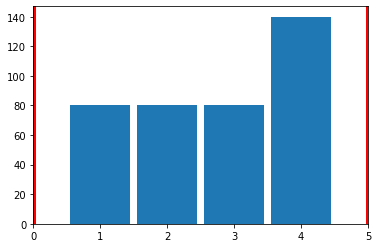

In [8]:
L, Z, p = 20, 4, 0
testC, testNetwork = ConstructNetwork(L, Z, p, returnNetwork=True)
pathLengths = FindAllPathLengths(testNetwork)
pathLengths = [pathLengths[i] for i in pathLengths.keys()]

plt.figure()
plt.hist(pathLengths, bins = range(max(pathLengths)+1), align='left', rwidth=.9)
plt.xticks([i for i in range(max(pathLengths)+1)])
plt.xlim(0,max(pathLengths))
plt.axvline(0, c='r', lw=5)
plt.axvline(L/Z, c='r', lw=5)
plt.show()
plt.close()

> Generate graphs at $L = 1,000$ and $Z = 2$ for $p = 0.02$ and $p = 0.2$; display the circle graphs and plot the histogram of path lengths. 

In [9]:
L, Z, p = 1000, 2, .02
testC, testNetwork = ConstructNetwork(L, Z, p, returnNetwork=True)
pathLengths = FindAllPathLengths(testNetwork)
pathLengths = [pathLengths[i] for i in pathLengths.keys()]

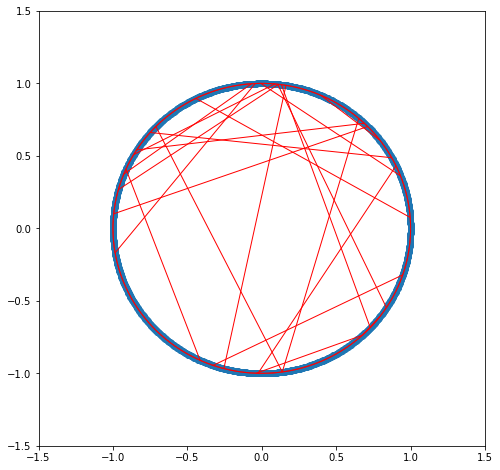

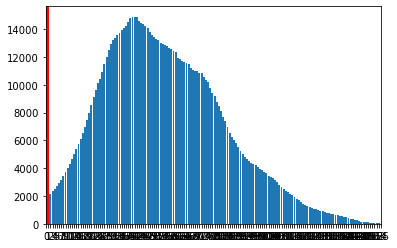

In [10]:
DrawNetwork(L, testC)
plt.figure()
plt.hist(pathLengths, bins = range(max(pathLengths)+1), align='left', rwidth=.9)
plt.xticks([i for i in range(max(pathLengths)+1)])
plt.xlim(0,max(pathLengths))
plt.axvline(0, c='r', lw=5)
plt.axvline(L/Z, c='r', lw=5)
plt.show()
plt.close()

In [ ]:
L, Z, p = 1000, 2, .2
testC, testNetwork = ConstructNetwork(L, Z, p, returnNetwork=True)
pathLengths = FindAllPathLengths(testNetwork)
pathLengths = [pathLengths[i] for i in pathLengths.keys()]

In [ ]:
plt.figure()
plt.hist(pathLengths, bins = range(max(pathLengths)+1), align='left', rwidth=.9)
plt.xticks([i for i in range(max(pathLengths)+1)])
plt.xlim(0,max(pathLengths))
plt.axvline(0, c='r', lw=5)
plt.axvline(L/Z, c='r', lw=5)
plt.show()
plt.close()

> Zoom in on the histogram; how much does it change with $p$? 

> What value of $p$ would you need to get “six degrees of separation”?

3. `FindAveragePathLength(graph)`, which computes the mean $〈\ell〉$ over all pairs of
nodes.

In [ ]:
def FindAveragePathLength(graph):
    d = FindAllPathLengths(graph)
    lengthsum = 0
    count = 0
    
    for key in d.keys():
        lengthsum += d[key]
        count += 1
        
    return lengthsum/count

> Compute $\ell$ for $Z = 2, L = 100$, and $p = 0.1$ a few times; your answer should be around $\ell = 10$. Notice that there are substantial statistical fluctuations in the value from sample to sample.


> Roughly how many long bonds are there in this system? Would you expect fluctuations in the distances?